# NEED TO ENSURE THAT DATASET IS AVAILABLE TO BE READ IN NON-LOCALLLY

In [1]:
# Required installations
!pip install shap==0.39.0

     |████████████████████████████████| 358kB 8.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491630 sha256=70f575fe45c1fb987b2eea668acbd404cc14847cc256510071772bbcfc579503
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [295]:
# Import the required modules
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from google.colab import files
import io

import shap
from IPython.display import Image
from IPython.core.display import HTML 
import operator
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
shap.initjs()

## Loading and Splitting Data

In [3]:
#read in the dataset
uploaded = files.upload()
heart = pd.read_csv(io.BytesIO(uploaded['heart.csv']))

heart.head()

Saving heart.csv to heart.csv


age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1   37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2   41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3   56    1   1       120   236    0  ...      0      0.8      2   0     2       1
4   57    0   0       120   354    0  ...      1      0.6      2   0     2       1

[5 rows x 14 columns]

In [170]:
#split data into X and y and scale the X as done in the ADS
X = heart[list(heart.columns)[0:-1]]
y = heart['target']

X_norm = normalize(X, norm='l2')

In [171]:
#split the dataset into train, val, test using the same seeds as the ADS
X_train, X_hold, y_train, y_hold = train_test_split(X_norm, y, test_size=0.33, random_state=101) 
X_val, X_test, y_val, y_test = train_test_split(X_hold, y_hold, test_size=0.5, random_state=42)

y_train = np.array(y_train)
y_hold = np.array(y_hold)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [172]:
#Splitting out additional dataframes with the unscaled data
X_check_train, X_thing = train_test_split(X, test_size=0.33, random_state=101) 
X_check_val, X_check_test = train_test_split(X_thing, test_size=0.5, random_state=42)

## Fitting Model
Use the same parameters and seed as the ADS

In [86]:
#run this model matching ADS params
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model.fit(X_train, y_train)

#confirm same prediction scores as ADS
print('Small Test Set')
print('Val score:',model.score(X_val, y_val))
print('Test score:',model.score(X_test, y_test))

print('Large Hold-out Set')
print('Test score:',model.score(X_hold, y_hold))

#save preditions on test data
preds_test = model.predict(X_test)
preds_hold = model.predict(X_hold)

Small Test Set
Val score: 0.78
Test score: 0.92
Large Hold-out Set
Test score: 0.85


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


## Explain the Model using Feature Importances

Unfourtunately because the ADS systems were are investigating uses sci-kit-learn's MLP classifyer, there is no feature importance method to determine the global weight of each feature.  Hence, we use the SHAP explainer below.

## Explain the model using SHAP

In [254]:
# Initialize the explainer -- had to sample down data to 75 due to model complexity
explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, nsamples=75, random_state=10))
# Apply it to the test data
shap_values = explainer.shap_values(X_hold)

Shap values: 
  - list with 2 elements
  - each element is a 50 x13 array
    - 13 is for each feature
    - 50 is for each test instance

Each list gives the shap values with respect to each output --- using 1 is the impact on target==1

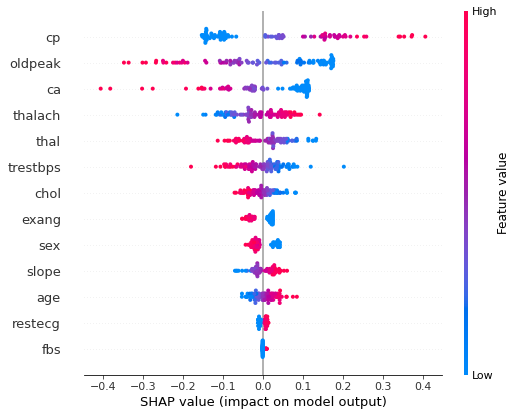

In [257]:
#Plot out shap summary for target==1 (positive diagnosis)
shap.summary_plot(shap_values[1], X_hold, feature_names=heart.columns[:-1])

## SHAP Values for Individual Cases

In [258]:
# Compute the accuracy of the classifier and the number of misclassified documents
print("misclassification count: {}".format(np.sum(preds_hold != y_hold)))
print('confusion matrix:')
confusion_matrix(y_hold, preds_hold)

misclassification count: 15
confusion matrix:


array([[38, 10],
       [ 5, 47]])

In [259]:
##create arrays of idices for TN, TP, and correct classification
FP_idx = np.argwhere((y_hold_preds - y_hold) == 1)[:,0]
FN_idx = np.argwhere((y_hold_preds - y_hold) == -1)[:,0]
TPTN_idx = np.argwhere((y_hold_preds - y_hold) == 0)[:,0]

#seperate FP by sex 
FP_female_idx = FP_idx[(X_hold[FP_idx,1] == 0)]
FP_male_idx = FP_idx[(X_hold[FP_idx,1] != 0)]

#seperate FN by sex 
FN_female_idx = FN_idx[(X_hold[FN_idx,1] == 0)]
FN_male_idx = FN_idx[(X_hold[FN_idx,1] != 0)]

#seperate TP by sex 
TPTN_female_idx = TPTN_idx[(X_hold[TPTN_idx,1] == 0)]
TPTN_male_idx = TPTN_idx[(X_hold[TPTN_idx,1] != 0)]

### False Positive Classifications

In [260]:
#False Positive Calssification for Female Example
shap.initjs()
idx = FP_female_idx[0]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Negative
Positive Diagnosis
Sex: Female


In [261]:
#False Positive Calssification for Male Example
shap.initjs()
idx = FP_male_idx[0]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Negative
Positive Diagnosis
Sex: Male


###False Negative Classification

In [262]:
#False Positive Calssification for Female Example
shap.initjs()
idx = FN_female_idx[0]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Positive
Negative Diagnosis
Sex: Female


In [264]:
#False Positive Calssification for male Example
shap.initjs()
idx = FN_male_idx[0]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Positive
Negative Diagnosis
Sex: Male


###Correct Classifications - Female

In [265]:
#Correct Positive Classification for Female
shap.initjs()
idx = TPTN_female_idx[0]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Positive
Positive Diagnosis
Sex: Female


In [266]:
#Correct Negative Classification for Female
shap.initjs()
idx = TPTN_female_idx[14]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Negative
Negative Diagnosis
Sex: Female


###Correct Classifications - Male

In [267]:
#Correct Negative Classification for Female
shap.initjs()
idx = TPTN_male_idx[1]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Positive
Positive Diagnosis
Sex: Male


In [268]:
#Correct Negative Classification for Male
shap.initjs()
idx = TPTN_male_idx[0]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Negative
Negative Diagnosis
Sex: Male


## Model Evaluation Using Transperancy Metrics
### Plotting Confidence

In [301]:
# Calculate conf_i for all misclassified documents
proba_misclf = model.predict_proba(X_hold[preds_hold != y_hold])
conf_misclf = proba_misclf[:,0] - proba_misclf[:,1]
patient_misclf = np.argwhere(preds_hold != y_hold)[:,0]

label_list = ['False Positive','False Negative']
misclf_matrix = np.vstack([patient_misclf,conf_misclf]).T
misclf_df = pd.DataFrame(misclf_matrix,columns=['patient_i','conf_i'])
misclf_df["label"] = (misclf_df["conf_i"] >0).astype(int)
misclf_df["label"] = misclf_df["label"].apply(lambda x: label_list[x])
misclf_df["conf_i"] = np.abs(misclf_df["conf_i"])
misclf_df["patient_i"] = misclf_df["patient_i"].astype(int)

misclf_df.label.value_counts()

False Positive    10
False Negative     5
Name: label, dtype: int64

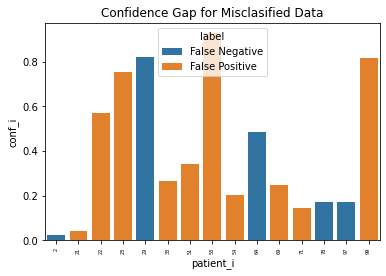

In [302]:
chart = sns.barplot(x="patient_i", y="conf_i", hue="label", data=misclf_df, dodge=False)
for item in chart.get_xticklabels():
    item.set_rotation(90)
    item.set_size(5)
plt.title('Confidence Gap for Misclasified Data')
plt.show()

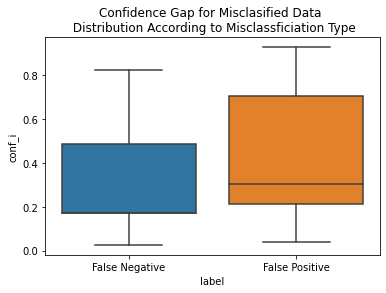

In [303]:
# Plot conf_i
plt.title('Confidence Gap for Misclasified Data \n Distribution According to Misclassficiation Type')
sns.boxplot(y="conf_i", x="label", data=misclf_df)
plt.show()

### Plotting Most impactful features (Globally)

In [352]:
gbl_feat_weight = defaultdict(float)
# gbl_feat_count = defaultdict(float)
feats = heart.columns[:-1]

for idx in range(len(y_hold)):
  vals = shap_values[1][idx,:]

  for feat_i, val_i in zip(feats, vals):
    # if val_i*msclf_array[idx] > 0:
    gbl_feat_weight[feat_i] += np.abs(val_i)
    # gbl_feat_count[feat_i] += 1


gbl_weights_df = pd.DataFrame([gbl_feat_weight]).T.reset_index()
gbl_weights_df.columns = ['feature','gbl_weight']
gbl_weights_df = gbl_weights_df.sort_values(['gbl_weight'], ascending=False)
gbl_weights_df

feature  gbl_weight
2         cp   13.403175
9    oldpeak   12.438578
11        ca    9.363446
7    thalach    5.605015
12      thal    4.727167
3   trestbps    4.342380
4       chol    2.719880
8      exang    2.429709
1        sex    2.367475
10     slope    2.357018
0        age    2.263810
6    restecg    0.825658
5        fbs    0.176548

Text(0.5, 1.0, 'Feature Importances for Global Classification')

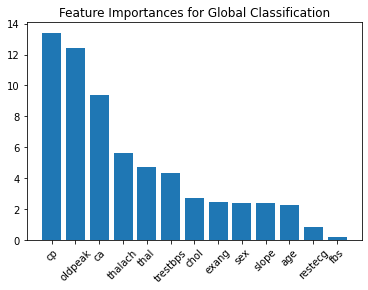

In [353]:
plt.bar(weight_df['feature'],gbl_df['gbl_weight'])
plt.xticks(rotation = 45)
plt.title('Feature Importances for Global Classification')

### Plotting Most Impactful Features (False Negative Misclassification)

In [354]:
FN_feat_weight = defaultdict(float)
FN_feat_count = defaultdict(float)
feats = heart.columns[:-1]
msclf_array = (preds_hold - y_hold)


for idx in FN_idx:
  vals = shap_values[1][idx,:]

  for feat_i, val_i in zip(feats, vals):
    if val_i*msclf_array[idx] > 0:
      FN_feat_weight[feat_i] += np.abs(val_i)
      FN_feat_count[feat_i] += 1


FN_weight_df = pd.DataFrame([FN_feat_weight]).T.reset_index()
FN_weight_df.columns = ['feature','FN_feat_weight']
FN_weight_df = FN_weight_df.sort_values(['FN_feat_weight'], ascending=False)
FN_weight_df

feature  FN_feat_weight
5    oldpeak        0.647994
0         cp        0.431830
9         ca        0.406764
8   trestbps        0.143282
4    thalach        0.127567
6      slope        0.100347
11       age        0.093416
7        sex        0.086374
10      thal        0.062295
1       chol        0.054784
3    restecg        0.025199
2        fbs        0.007776

Text(0.5, 1.0, 'Feature Importances for Global Classification')

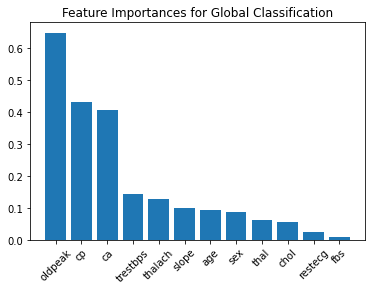

In [355]:
plt.bar(FN_weight_df['feature'],FN_weight_df['FN_feat_weight'])
plt.xticks(rotation = 45)
plt.title('Feature Importances for Global Classification')

### Plotting Most Impactful Features (False Negative Misclassification for Males, the Impacted class)

In [356]:
FN_male_feat_weight = defaultdict(float)
FN_male_feat_count = defaultdict(float)
feats = heart.columns[:-1]
# msclf_array = (preds_hold - y_hold)


for idx in FN_male_idx:
  vals = shap_values[1][idx,:]

  for feat_i, val_i in zip(feats, vals):
    if val_i*msclf_array[idx] > 0:
      FN_male_feat_weight[feat_i] += np.abs(val_i)
      FN_male_feat_count[feat_i] += 1


FN_male_weight_df = pd.DataFrame([FN_male_feat_weight]).T.reset_index()
FN_male_weight_df.columns = ['feature','FN_male_feat_weight']
FN_male_weight_df = FN__male_weight_df.sort_values(['FN_male_feat_weight'], ascending=False)
FN_male_weight_df

feature  FN_male_feat_weight
9    oldpeak             0.637113
5         ca             0.406764
7         cp             0.290276
1   trestbps             0.143282
10       age             0.093416
0        sex             0.086374
4      slope             0.082060
6       thal             0.062295
3    thalach             0.053896
8    restecg             0.012462
2        fbs             0.006055

Text(0.5, 1.0, 'Feature Importances for False Negative Classification of Males')

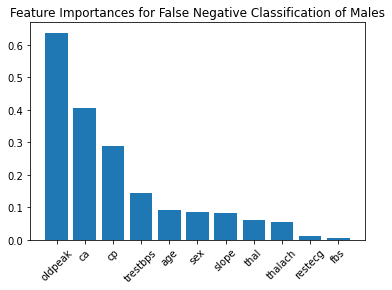

In [357]:
plt.bar(FN__male_weight_df['feature'],FN__male_weight_df['FN_male_feat_weight'])
plt.xticks(rotation = 45)
plt.title('Feature Importances for False Negative Classification of Males')

## Model Repair Using Transparency Metrics


## Prediction Decomposition (Jack Stuff)

AM I READING IN THE WRONG VALUES FOR Y_TEST?

In [ ]:
#aggregated all incorrect predicitons on the test data
df = pd.DataFrame(columns=['preds', 'actuals'])
df['preds'] = model.predict(X_test)
df['actuals'] = y_test

wrong = df.loc[(df.preds == True) & (df.actuals == False)]
wrong = wrong.append(df.loc[(df.preds == False) & (df.actuals == True)])

wrong.index

Int64Index([9, 12, 15, 16, 17, 37], dtype='int64')

In [ ]:
#show prediction decomposition for various test instances
shap.initjs()
idx = 0

print("Positive" if y_test[y_test.index[idx]] else "Negative", "Diagnosis")
print("Positive" if y_preds[idx] else "Negative", "Prediction")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_test[idx,:],
    feature_names=heart.columns[:-1])

Negative Diagnosis
Negative Prediction


In [ ]:
shap.initjs()
idx = 10

print("Positive" if y_test[y_test.index[idx]] else "Negative", "Diagnosis")
print("Positive" if y_preds[idx] else "Negative", "Prediction")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_test[idx,:],
    feature_names=heart.columns[:-1])

Positive Diagnosis
Positive Prediction


In [ ]:
# Checking the features that contribute to the positive and negative classification of document 10
idx = 10
vals = shap_values[1][idx,:]
positive_diagnosis_weight = defaultdict(float)
negative_diagnosis_weight = defaultdict(float)
feats = heart.columns[:-1]

for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    positive_diagnosis_weight[feat_i] += val_i
  elif val_i < 0:
    negative_diagnosis_weight[feat_i] += val_i

In [ ]:
list(sorted(positive_sentiment_weight.items(), key=operator.itemgetter(1), reverse=True))[:10]

[('oldpeak', 0.16553880499087653),
 ('thalach', 0.09159364130089137),
 ('ca', 0.07723440685408495),
 ('thal', 0.03648229329024544),
 ('chol', 0.02866228890418729),
 ('slope', 0.026213547467968695),
 ('exang', 0.02428360744219249),
 ('trestbps', 0.022552806730968045)]

In [ ]:
list(sorted(negative_sentiment_weight.items(), key=operator.itemgetter(1)))[:10]

[('cp', -0.0873672857318941),
 ('sex', -0.020529054396008592),
 ('age', -0.011254768319432285),
 ('restecg', -0.008480521854934808),
 ('fbs', -0.0015092541153690908)]

#### Look at the incorrect predictions in the test data and find weights of features driving those predictions

In [ ]:
positive_diagnosis_weight = defaultdict(float)
negative_diagnosis_weight = defaultdict(float)

for w in wrong.index:
  vals = shap_values[1][w,:]

  for feat_i, val_i in zip(feats, vals):

    if val_i > 0:
      positive_diagnosis_weight[feat_i] += val_i
    elif val_i < 0:
      negative_diagnosis_weight[feat_i] += val_i


In [ ]:
list(sorted(positive_sentiment_weight.items(), key=operator.itemgetter(1), reverse=True))[:10]

[('oldpeak', 0.16553880499087653),
 ('thalach', 0.09159364130089137),
 ('ca', 0.07723440685408495),
 ('thal', 0.03648229329024544),
 ('chol', 0.02866228890418729),
 ('slope', 0.026213547467968695),
 ('exang', 0.02428360744219249),
 ('trestbps', 0.022552806730968045)]

In [ ]:
list(sorted(negative_sentiment_weight.items(), key=operator.itemgetter(1)))[:10]

[('cp', -0.0873672857318941),
 ('sex', -0.020529054396008592),
 ('age', -0.011254768319432285),
 ('restecg', -0.008480521854934808),
 ('fbs', -0.0015092541153690908)]